# OPA2Vec

In this part of the tutorial, we run two ontology based methods to produce vector representations of biological entities: OPA2Vec.

## Imports

In [1]:
import sys
import os
sys.path.append('../../../')
from mowl.datasets.ppi_yeast import PPIYeastSlimDataset, PPIYeastDataset
from mowl.embeddings.opa2vec.model import OPA2Vec

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

## Loading the dataset

In [2]:
dataset = PPIYeastSlimDataset()

## OPA2Vec

Onto2vec produces vectory representations based on the logical axioms of an ontology and the known associations between ontology classes and biological entities. In the case study below, we use Onto2vec to produce vector representations of proteins based on their GO annotations and the GO logical axioms.

In [3]:
model = OPA2Vec(dataset)

Train the model

In [4]:
model.train()

0     [main] INFO  org.semanticweb.elk.config.ConfigurationFactory  - Loading default configuration parameters for class org.semanticweb.elk.reasoner.config.ReasonerConfiguration
180   [main] INFO  org.semanticweb.elk.reasoner.Reasoner  - ELK reasoner was created
184   [main] INFO  org.semanticweb.elk.reasoner.stages.LoggingStageExecutor  - Loading of Axioms started
215   [main] INFO  org.semanticweb.elk.reasoner.stages.AbstractReasonerStage  - Loading of Axioms using 8 workers
Loading of Axioms ...
Loading ...
    1%
    2%
    3%
    4%
    5%
    6%
    7%
    8%
    9%
    10%
    11%
    12%
    13%
    14%
    15%
    16%
    17%
    18%
    19%
    20%
    21%
    22%
    23%
    24%
    25%
    26%
    27%
    28%
    29%
    30%
    31%
    32%
    33%
    34%
    35%
    36%
    37%
    38%
    40%
    41%
    42%
    43%
    44%
    45%
    47%
836   [main] WARN  org.semanticweb.elk.reasoner.indexing.hierarchy.ChangeIndexingProcessor  - [reasoner.indexing.axiomIgnored]ELK do

836   [main] WARN  org.semanticweb.elk.reasoner.indexing.hierarchy.ChangeIndexingProcessor  - [reasoner.indexing.axiomIgnored]ELK does not support InverseObjectProperties. Axiom ignored:
InverseObjectProperties(<http://purl.obolibrary.org/obo/BFO_0000050> <http://purl.obolibrary.org/obo/BFO_0000051>)


    53%
    54%
    55%
    56%
    57%
    58%
    60%
    61%
    62%
    64%
    65%
    66%
    68%
    69%
    70%
    71%
    72%
    73%
    75%
    76%
    77%
    78%
    79%
    81%
    82%
    83%
    84%
    86%
    87%
    88%
    89%
    91%
    92%
    93%
    94%
    96%
    97%
    98%
    99%
    ... finished
    ... finished
1312  [main] INFO  org.semanticweb.elk.reasoner.stages.LoggingStageExecutor  - Loading of Axioms took 1098 ms
1312  [main] INFO  org.semanticweb.elk.reasoner.stages.LoggingStageExecutor  - Property Saturation Initialization started
1313  [main] INFO  org.semanticweb.elk.reasoner.stages.AbstractReasonerStage  - Property Saturation Initialization using 8 workers
Property Saturation Initialization ...
    ... finished
1313  [main] INFO  org.semanticweb.elk.reasoner.stages.LoggingStageExecutor  - Property Saturation Initialization took 0 ms
1313  [main] INFO  org.semanticweb.elk.reasoner.stages.LoggingStageExecutor  - Reflexive Property Computation s

Evaluate PPI prediction performance

In [5]:
mean_rank, rank_1, rank_10, rank_100 = model.evaluate_ppi()
print(f'Mean rank: {mean_rank}, Top 1: {rank_1}, Top 10: {rank_10}, Top 100: {rank_100}')

Mean rank: 1053.630704530313, Top 1: 218, Top 10: 1308, Top 100: 4704


In [6]:
nodemap = {}
embeddings = model.w2v_model.wv

In [7]:
n = len(embeddings)
emb_size = len(embeddings[0])
embeds = np.zeros((n, emb_size), dtype=np.float32)
for i in range(n):
    embeds[i, :] = embeddings[i]
X = TSNE(n_components=2, verbose=1, n_iter=2500).fit_transform(embeds)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7928 samples in 0.001s...


/Users/coolmaksat/opt/anaconda3/envs/mowl-jupyter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/coolmaksat/opt/anaconda3/envs/mowl-jupyter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 7928 samples in 1.761s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7928
[t-SNE] Computed conditional probabilities for sample 2000 / 7928
[t-SNE] Computed conditional probabilities for sample 3000 / 7928
[t-SNE] Computed conditional probabilities for sample 4000 / 7928
[t-SNE] Computed conditional probabilities for sample 5000 / 7928
[t-SNE] Computed conditional probabilities for sample 6000 / 7928
[t-SNE] Computed conditional probabilities for sample 7000 / 7928
[t-SNE] Computed conditional probabilities for sample 7928 / 7928
[t-SNE] Mean sigma: 0.059722
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.055672
[t-SNE] KL divergence after 2500 iterations: 1.564459


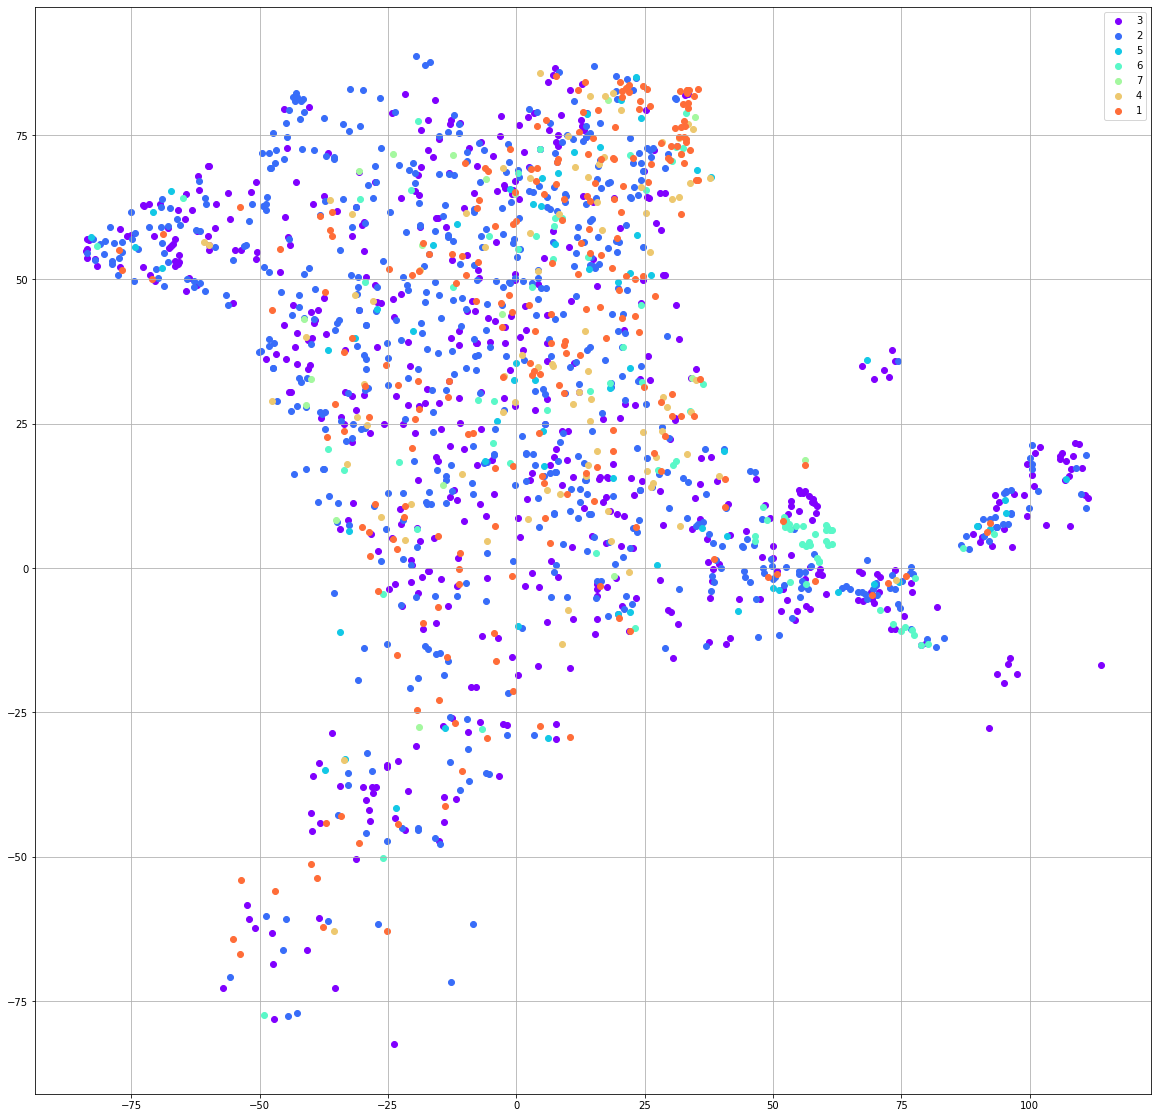

In [8]:
ec_numbers = {}
with open('../../../data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
classes = {'0': [[], []]}
for i in range(n):
    v = embeddings.index_to_key[i]
    if not v.startswith('<http://4932'):
        continue
    v = v[8:-1]
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[i, 0])
        classes[ec][1].append(X[i, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()